In [7]:
import requests
import time
import json
import matplotlib.pyplot as plt
import pandas as pd
import os

In [3]:
# get current directory
WORK_DIR = os.getcwd()
print("Working directory:", WORK_DIR)

Working directory: /home/ubuntu/power-consumption-tool/power-metrics-per-pod-realtime


In [9]:
# Prometheus server URL
PROMETHEUS_URL = "http://192.169.122.115:32236"
# Prometheus query to fetch the metric in watts if greater than 0.01
QUERY = 'scaph_process_power_consumption_microwatts{container_scheduler="docker"} / 1000000 > 0.01'
SAVE_FILE_PATH_DATA = f"{WORK_DIR}/data/pc-time-containers.json"
SAVE_FILE_PATH_PLOT = f"{WORK_DIR}/figures/pc-time-containers.png"
POD_DATA=f"{WORK_DIR}/data/all_pod_metrics.json"
search_term = 'oai-upf'  # Change this to your search term
ip_address = '12.1.1.100'  # Change this to your target IP address
value = '80'  # iperf MB bandwidth


In [10]:
def fetch_metrics():
    """Fetches metrics from Prometheus and returns a dictionary of values by container ID."""
    response = requests.get(f"{PROMETHEUS_URL}/api/v1/query", params={'query': QUERY})
    metrics_by_container = {}

    if response.status_code == 200:
        try:
            result = response.json()
            for entry in result['data']['result']:
                # Extract container_id and metric value
                container_id = entry['metric'].get('container_id', 'unknown')
                value = float(entry['value'][1])
                cmdline= entry['metric'].get('cmdline', 'unknown')
                timestamp = time.time()

                # Initialize list if container_id not in dictionary
                if container_id not in metrics_by_container:
                    metrics_by_container[container_id] = []
                
                # Append timestamped metric
                metrics_by_container[container_id].append({'timestamp': timestamp, 'value': value, 'cmdline':cmdline})
                
            return metrics_by_container
        except (IndexError, KeyError):
            print("Error parsing metrics.")
            return {}
    else:
        print(f"Failed to fetch metrics. Status code: {response.status_code}")
        return {}

def collect_metrics(duration):
    """Collects metrics for the specified duration and saves them to a JSON file."""
    metrics_over_time = {}
    start_time = time.time()

    while time.time() - start_time < duration:
        metrics = fetch_metrics()
        for container_id, data_points in metrics.items():
            if container_id not in metrics_over_time:
                metrics_over_time[container_id] = []
            metrics_over_time[container_id].extend(data_points)
        time.sleep(0.5)  # Collect every half of second

    # Save metrics to JSON file
    with open(SAVE_FILE_PATH_DATA, "w") as f:
        json.dump(metrics_over_time, f)
    
    print(f"Metrics saved to '{SAVE_FILE_PATH_DATA}'")
    return metrics_over_time

In [11]:
# Load pod data from JSON file
try:
    with open(POD_DATA, "r") as f:
        pod_data = json.load(f)
except FileNotFoundError:
    print(f"{POD_DATA} not found. Please collect the pod metrics first.")

# Initialize a dictionary to map uids to pod names
uid_pod_map = {}

# Retrieve all the uids and their corresponding pod names
for namespace, pods in pod_data.items():
    for pod_name, pod_info in pods.items():
        # Access the metadata to get the uid
        uid = pod_info.get('metadata', {}).get('uid', None)

        if uid:  # Check if uid exists
            uid_pod_map[uid] = pod_name

# Convert the mapping to a DataFrame
uid_pod_df = pd.DataFrame(list(uid_pod_map.items()), columns=['UID', 'Pod Name'])

# Optionally, print the DataFrame
print(uid_pod_df)

# Save the DataFrame to a CSV file (optional)
uid_pod_df.to_csv("uid_pod_mapping.csv", index=False)


/home/ubuntu/power-consumption-tool/power-metrics-per-pod-realtime/data/all_pod_metrics.json not found. Please collect the pod metrics first.


NameError: name 'pod_data' is not defined

In [5]:
def load_uid_pod_map(csv_file_path):
    """Loads UID to pod name mapping from a CSV file and returns it as a dictionary."""
    try:
        # Load the CSV file into a DataFrame
        df = pd.read_csv(csv_file_path)
        # Create a dictionary mapping UIDs to pod names
        uid_pod_map = dict(zip(df['UID'], df['Pod Name']))
        return uid_pod_map
    except FileNotFoundError:
        print(f"{csv_file_path} not found.")
        return {}

In [9]:

def plot_metrics(file_path_data, save_file_path_plot, uid_pod_map, interval=2):
    """Reads metrics from the JSON file, downsamples to the specified interval, and plots them."""
    # Load data from JSON file
    try:
        with open(file_path_data, "r") as f:
            metrics_over_time = json.load(f)
    except FileNotFoundError:
        print(f"{file_path_data} not found. Please collect metrics first.")
        return

    plt.figure(figsize=(20, 10))

    # Plot each container's data with a unique color
    for container_id, container_data in metrics_over_time.items():
        downsampled_data = []
        last_timestamp = None
        
        # Initialize pod name with a default value
        pod_name = "unknown"  # Default value
        
        # Downsample the data to show points every `interval` seconds
        for entry in container_data:
            timestamp = entry['timestamp']
            value = entry['value']
            
            # Find the corresponding pod name from the uid_pod_map
            for uid, name in uid_pod_map.items():
                if uid.endswith(container_id):
                    pod_name = name  # Use the mapped pod name
                    break  # Exit loop once we find the match

            # Add the first data point or any data point at least `interval` seconds after the last
            if last_timestamp is None or (timestamp - last_timestamp) >= interval:
                downsampled_data.append((timestamp, value))
                last_timestamp = timestamp

        # Normalize timestamps to start from 0
        if downsampled_data:
            min_timestamp = downsampled_data[0][0]
            normalized_times = [(t[0] - min_timestamp) for t in downsampled_data]
            values = [t[1] for t in downsampled_data]
            
            # Plot the downsampled data for this container using the pod name as label
            plt.plot(normalized_times, values, marker='o', linestyle='-', label=pod_name)

    plt.xlabel("Elapsed Time (s)")
    plt.ylabel("Power Consumption (Watts)")
    plt.title("Power Consumption Over Time by Pod Name")
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.40), ncol=1)  # Centered at bottom
    plt.tight_layout()

    # Save the plot to a file
    plt.savefig(save_file_path_plot)
    print(f"Plot saved as {save_file_path_plot}")

Plot saved as figures/pc-time-containers.png


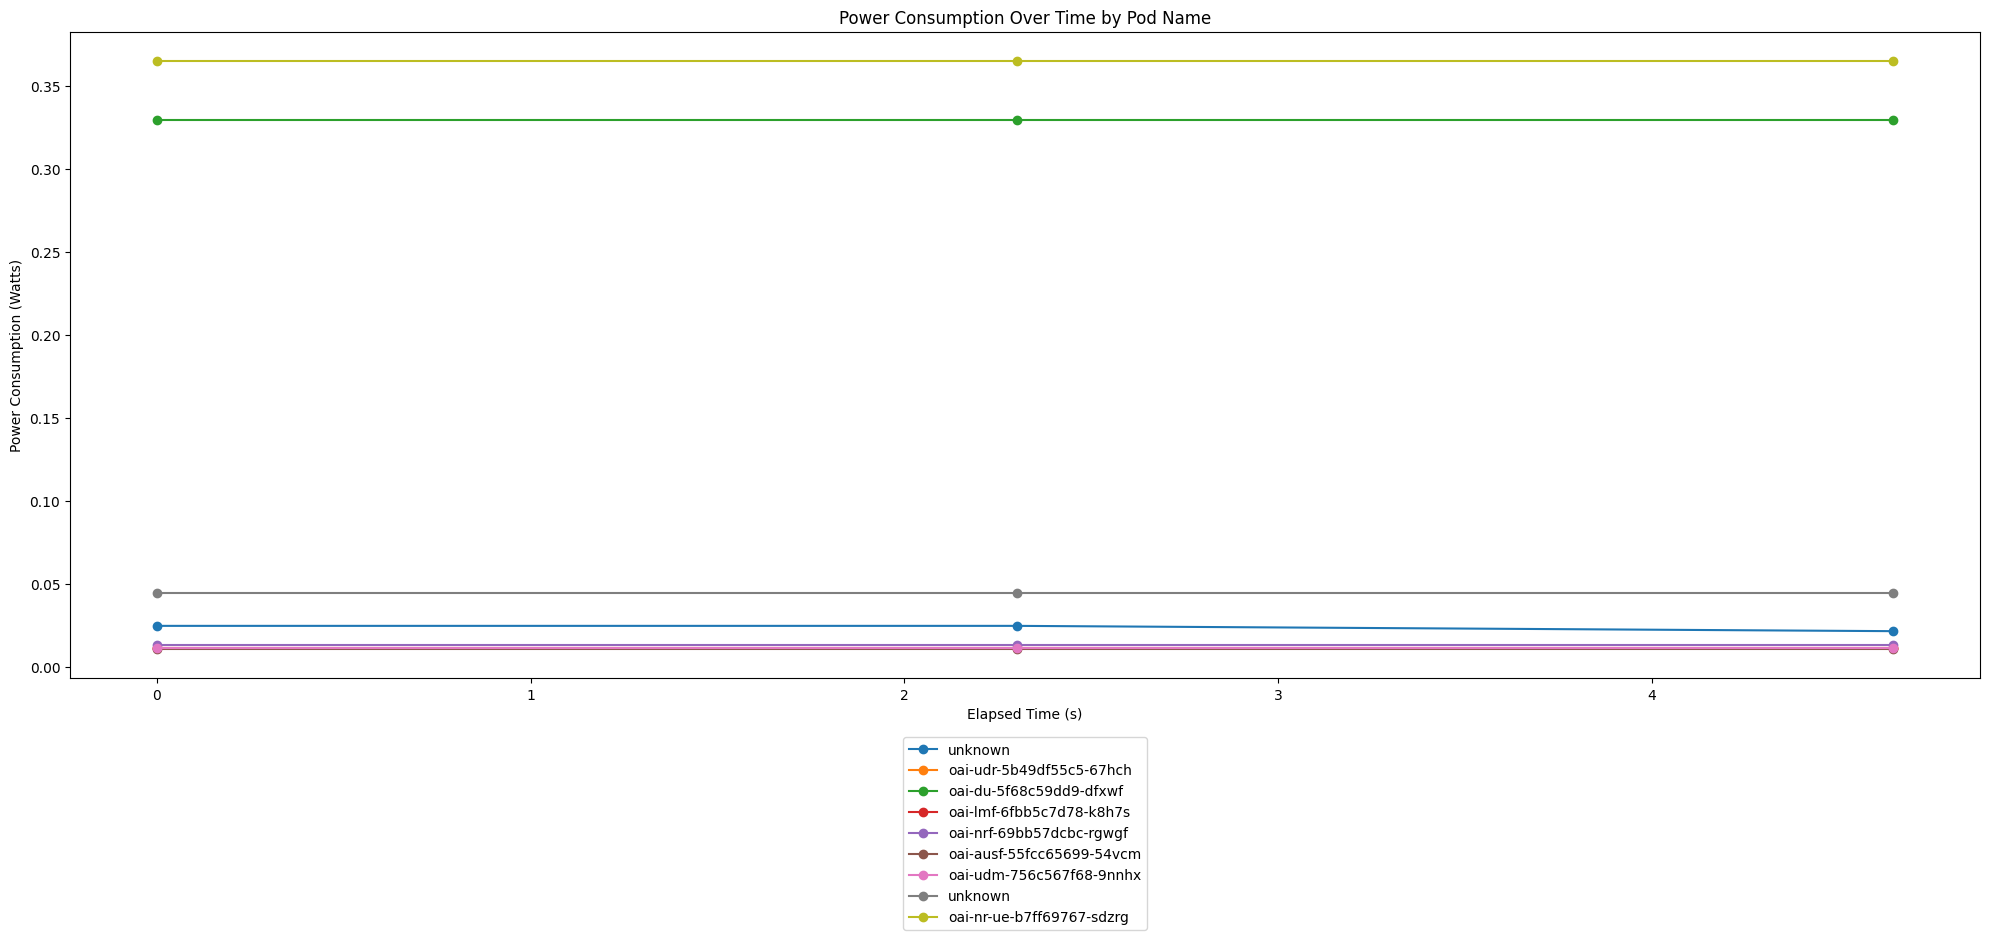

In [10]:
# Collect metrics and plot them
# collect_metrics(duration=5)

# Load the UID to pod mapping from the CSV file
uid_pod_map = load_uid_pod_map('/home/caterina/ee-5g/plots/uid_pod_mapping.csv')  # Update this path to your actual CSV file

# Plot the metrics
plot_metrics(SAVE_FILE_PATH_DATA, SAVE_FILE_PATH_PLOT, interval=2, uid_pod_map=uid_pod_map)